In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_aruco
import utils_icp
import copy
from utils_data_process import *
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.image as mpimg
from scipy.optimize import curve_fit

data_folder = './data-raw'
# plt.rcParams['mathtext.fontset'] = 'custom'

plt.rcParams['mathtext.default'] = 'regular'  # Use regular text for mathtext by default
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

# Optionally, you can also set the default font family to Arial for consistency
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize_main = 20
fontsize_legend = 14
# import sys
# import importlib
# importlib.reload(sys.modules['utils_data_process'])



In [67]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic",
]

tag_offset_dict = {
    3: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_3', 'camera_4', 'camera_5', 'camera_2', 'camera_10', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE', 'camera_37', 'camera_17']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


ax_angle: (2, 3)
n cycle 5 cycle len 200
{3: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 4: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 5: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 2: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 10: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463])}
fitted circle: x 696.23 y 584.68 r 81.08 sigma 0.80
fitted circle: x 4.80 y -7.49 r 11.68 sigma 0.09
angles -85.91933148337156 274.0514409679553
start_idx: 1504, end_idx: 3005
xc: 4.801386620768036, yc: -7.485893717341803
start_idx: 3005, end_idx: 4506
xc: 4.801386620768036, yc: -7.485893717341803
start_idx: 4506, end_idx: 6008
xc: 4.801386620768036, yc: -7.485893717341803
start_idx: 

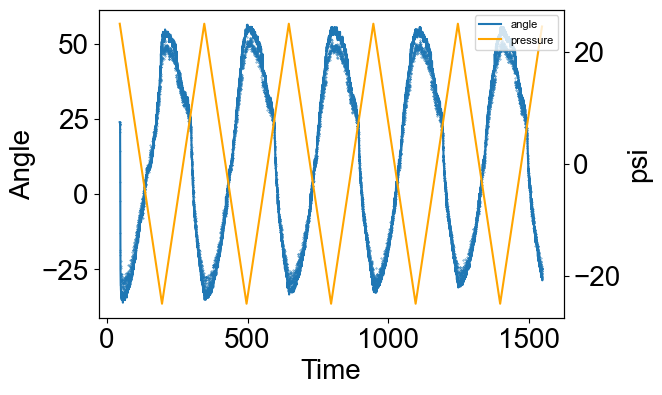

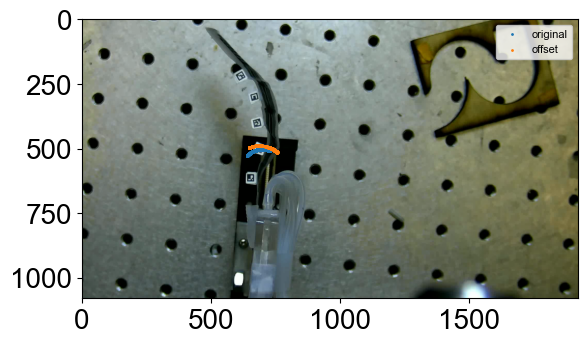

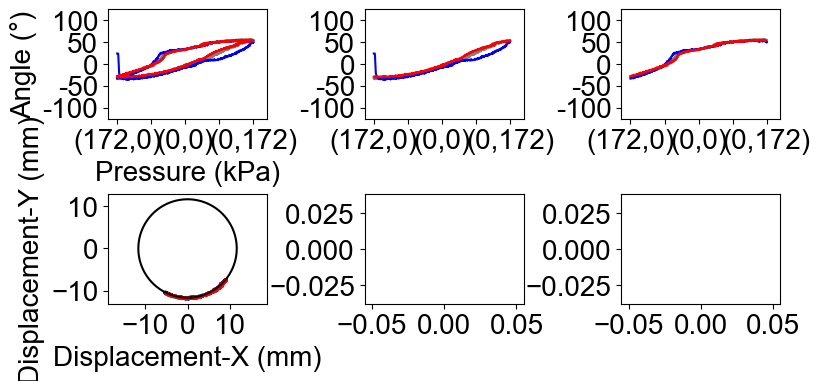

In [68]:
from utils_data_process import *
index_of_tag = 0
index_of_actuator = 0
n_cycle = 5
base_angle = 0
plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 3, figsize = (8, 4))
fig.tight_layout()
print(f"ax_angle: {np.shape(ax_angle)}")
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time

        top_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])
        top_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][top_mask] - base_angle
        bot_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])
        bot_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][bot_mask] - base_angle
        # print(f"top_y_mask: {top_mask}, bot_y_mask: {bot_mask}")
        # print(f"top_y: {top_y}, bot_y: {bot_y}")
        #print(camera_data_dict['t_cycle_top'][tag_of_desired])
        line = ax_angle[0][1].plot((camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]), 
                top_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        line = ax_angle[0][2].plot((camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]), 
                bot_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1][0]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    #ax.legend()
print(lines)
for i, ax in enumerate(ax_angle[0]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        # legend = ax.legend(legend_handles, legend_labels, ncol=1, 
        #                 labelspacing=0.1, 
        #                 columnspacing =0.05,
        #                 loc='upper right', 
        #                 handletextpad=0.1, 
        #                 fontsize=fontsize_legend
        #                 )

for i, ax in enumerate(ax_angle[1]):
    ax.axis('equal')
    #ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    #if i == 0:
        #ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

In [4]:
import scipy.interpolate

In [5]:
def interp(x_vals, y_vals):
    return scipy.interpolate.interp1d(x_vals, y_vals, fill_value = "extrapolate", kind = "cubic")

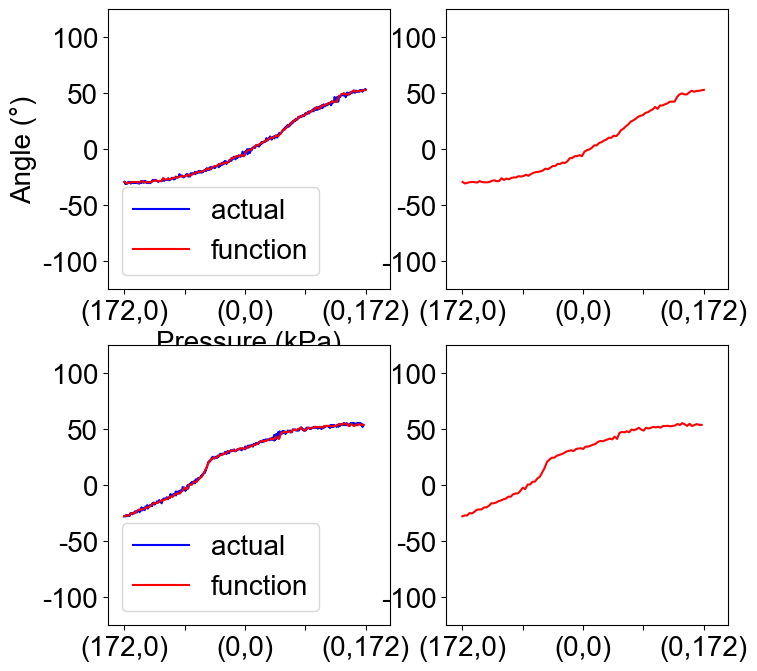

In [69]:

fig, axs = plt.subplots(2, 2, figsize = (8, 8))
top_x = camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]
top_func = scipy.interpolate.interp1d(top_x, top_y)
x = np.linspace(min(top_x), max(top_x), 100)
axs[0][0].plot(top_x, top_y, color = "blue", label = "actual") #plotting angle vs time
axs[0][0].plot(x, top_func(x), color = "red", label = "function")
axs[0][1].plot(x, top_func(x), color = "red", label = "function")
axs[0][0].legend()

bot_x = camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]
bot_func = scipy.interpolate.interp1d(bot_x, bot_y, fill_value = "extrapolate", kind = "quadratic")
x = np.linspace(min(bot_x), max(bot_x), 100)
axs[1][0].plot(bot_x, bot_y, color="blue", label = "actual")
axs[1][0].plot(x, bot_func(x), color = "red", label = "function")
axs[1][1].plot(x, bot_func(x), color = "red", label = "function")
axs[1][0].legend()

for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )

In [71]:
top_func_inverted = scipy.interpolate.interp1d(top_y, top_x)
bot_func_inverted = scipy.interpolate.interp1d(bot_y, bot_x)
import utils_file
folder_name = f"{utils_file.getCurrPath()}/Data"

if utils_file.isPath(f"{folder_name}/data.pickle"):
    saved_data = utils_file.openFile(folder_name)

    saved_data["top_function_1"] = top_func_inverted
    saved_data["bottom_function_1"] = bot_func_inverted

    utils_file.saveFile(folder_name, saved_data)
                
else:
    data = {"top_function_1": top_func_inverted, "bottom_function_1": bot_func_inverted}
    utils_file.saveFile(folder_name, data)

In [72]:
saved_data = utils_file.openFile(folder_name)
top_func = saved_data["top_function_1"]
bot_func = saved_data["bottom_function_1"]
y = np.linspace(min(bot_y), max(bot_y), 100)
plt.plot(y, bot_func(y), color = "red", label = "function")



/Users/eugeneng/BML/bml-eugene/env/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eugeneng/BML/bml-eugene/env/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


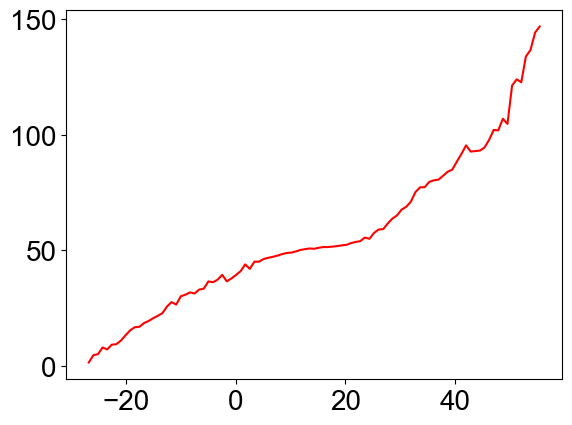

In [33]:
# we want to map angle to output pressure, so we need to revert this, also map input and output respectively
print(min(bot_x), max(bot_x))

0.014360666275024414 148.57915019989014


In [50]:
# we need to linearly map this to -25, 25
scaling_factor = 50 / ((max(top_x) - min(top_x)))

min(bot_x) * scaling_factor - 25
max(bot_x) * scaling_factor - 25

24.589663611021273

In [75]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240820_15-42-30_act_2_kinematic",
]

tag_offset_dict = {
    4: {
        'rot': 180,
        'disp': [-3.25, -3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240820_15-42-30_act_2_kinematic/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240820_15-42-30_act_2_kinematic/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240820_15-42-30_act_2_kinematic/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_3', 'camera_4', 'camera_5', 'camera_2', 'camera_10', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


ax_angle: (2, 3)
n cycle 5 cycle len 200
{3: array([  32.39111423,   32.45258331,   32.62758017, ..., 1533.65566802,
       1533.87972927, 1534.0572412 ]), 4: array([  32.39111423,   32.45258331,   32.62758017, ..., 1533.65566802,
       1533.87972927, 1534.0572412 ]), 5: array([  32.39111423,   32.45258331,   32.62758017, ..., 1533.65566802,
       1533.87972927, 1534.0572412 ]), 2: array([  32.39111423,   32.45258331,   32.62758017, ..., 1533.65566802,
       1533.87972927, 1534.0572412 ]), 10: array([  32.39111423,   32.45258331,   32.62758017, ..., 1533.65566802,
       1533.87972927, 1534.0572412 ])}
fitted circle: x 746.01 y 543.38 r 152.76 sigma 1.90
fitted circle: x 10.53 y -18.02 r 18.04 sigma 0.16
angles -85.92164538044516 274.04957134842067
start_idx: 1505, end_idx: 3007
top_y_mask: [ True  True  True ... False False False], bot_y_mask: [False False False ...  True  True  True]
top_y: [-18.800262   -19.433044   -19.433044   -20.740662   -19.749138
 -22.055344   -19.811134   

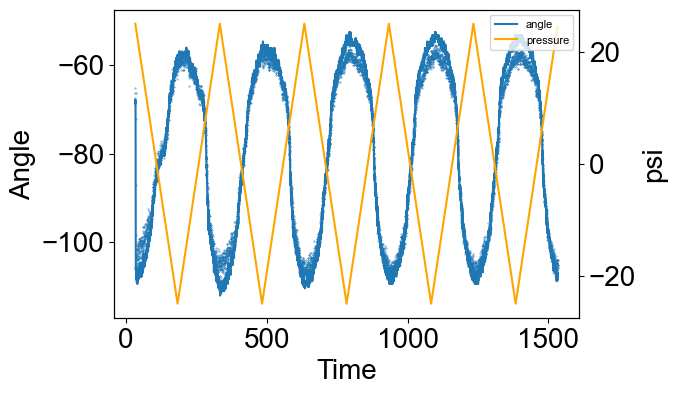

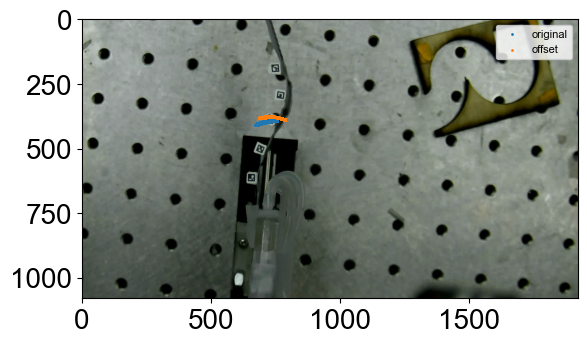

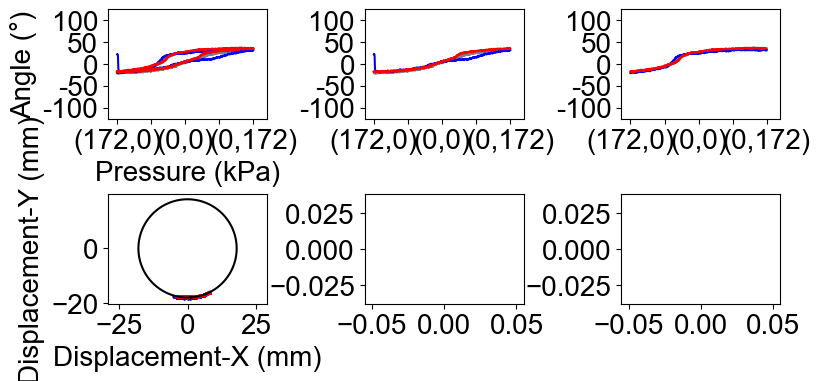

In [76]:
from utils_data_process import *

index_of_tag = 1
index_of_actuator = 1
n_cycle = 5
base_angle = -90

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 3, figsize = (8, 4))
fig.tight_layout()
print(f"ax_angle: {np.shape(ax_angle)}")
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time

        top_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])
        top_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][top_mask] - base_angle
        bot_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])
        bot_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][bot_mask] - base_angle
        print(f"top_y_mask: {top_mask}, bot_y_mask: {bot_mask}")
        print(f"top_y: {top_y}, bot_y: {bot_y}")
        #print(camera_data_dict['t_cycle_top'][tag_of_desired])
        line = ax_angle[0][1].plot((camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]), 
                top_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        line = ax_angle[0][2].plot((camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]), 
                bot_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1][0]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    #ax.legend()
print(lines)
for i, ax in enumerate(ax_angle[0]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        # legend = ax.legend(legend_handles, legend_labels, ncol=1, 
        #                 labelspacing=0.1, 
        #                 columnspacing =0.05,
        #                 loc='upper right', 
        #                 handletextpad=0.1, 
        #                 fontsize=fontsize_legend
        #                 )

for i, ax in enumerate(ax_angle[1]):
    ax.axis('equal')
    #ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    #if i == 0:
        #ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

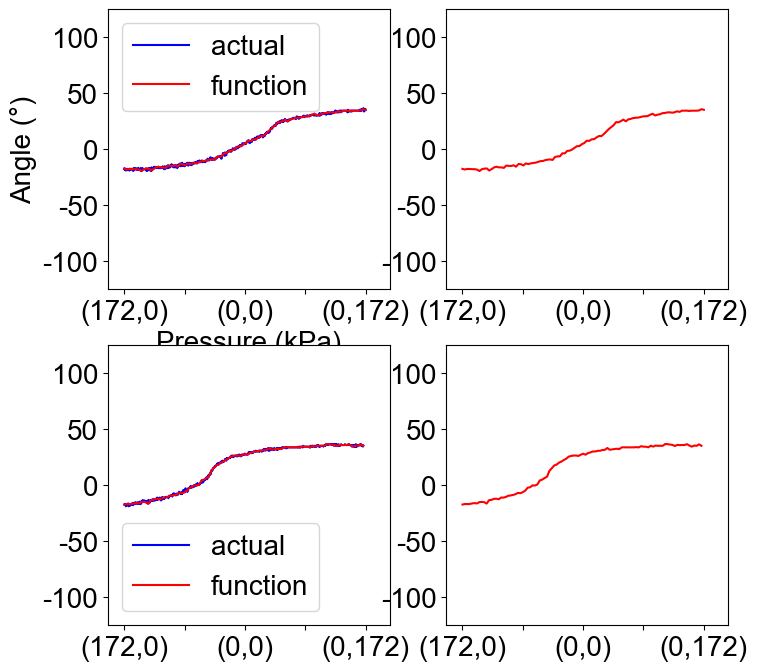

In [86]:

fig, axs = plt.subplots(2, 2, figsize = (8, 8))
top_x = camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]
top_func = scipy.interpolate.interp1d(top_x, top_y)
x = np.linspace(min(top_x), max(top_x), 100)
axs[0][0].plot(top_x, top_y, color = "blue", label = "actual") #plotting angle vs time
axs[0][0].plot(x, top_func(x), color = "red", label = "function")
axs[0][1].plot(x, top_func(x), color = "red", label = "function")
axs[0][0].legend()

bot_x = camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]
bot_func = scipy.interpolate.interp1d(bot_x, bot_y, fill_value = "extrapolate", kind = "quadratic")
x = np.linspace(min(bot_x), max(bot_x), 100)
axs[1][0].plot(bot_x, bot_y, color="blue", label = "actual")
axs[1][0].plot(x, bot_func(x), color = "red", label = "function")
axs[1][1].plot(x, bot_func(x), color = "red", label = "function")
axs[1][0].legend()

for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )

In [87]:
top_func_inverted = scipy.interpolate.interp1d(top_y, top_x, fill_value = "extrapolate")
bot_func_inverted = scipy.interpolate.interp1d(bot_y, bot_x, fill_value = "extrapolate")
import utils_file
folder_name = f"{utils_file.getCurrPath()}/Data"

if utils_file.isPath(f"{folder_name}/data.pickle"):
    saved_data = utils_file.openFile(folder_name)

    saved_data["top_function_2"] = top_func_inverted
    saved_data["bottom_function_2"] = bot_func_inverted

    utils_file.saveFile(folder_name, saved_data)
                
else:
    data = {"top_function_2": top_func_inverted, "bottom_function_2": bot_func_inverted}
    utils_file.saveFile(folder_name, data)


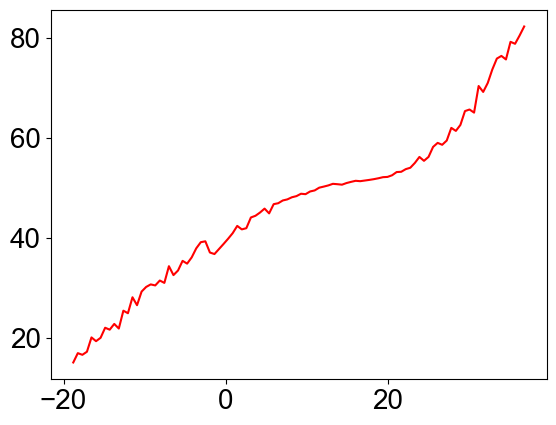

In [88]:
saved_data = utils_file.openFile(folder_name)
top_func = saved_data["top_function_2"]
bot_func = saved_data["bottom_function_2"]
y = np.linspace(min(bot_y), max(bot_y), 100)
plt.plot(y, bot_func(y), color = "red", label = "function")



In [89]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240820_15-14-42_act_3_kinematic",
]

tag_offset_dict = {
    10: {
        'rot': 180,
        'disp': [-3.25, -3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240820_15-14-42_act_3_kinematic/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240820_15-14-42_act_3_kinematic/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240820_15-14-42_act_3_kinematic/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_4', 'camera_5', 'camera_2', 'camera_10', 'camera_3', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE', 'camera_37', 'camera_17']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


ax_angle: (2, 3)
n cycle 5 cycle len 200
{4: array([  44.14362025,   44.22035503,   44.43016267, ..., 1544.85000467,
       1545.0577426 , 1545.26641989]), 5: array([  44.14362025,   44.22035503,   44.43016267, ..., 1544.85000467,
       1545.0577426 , 1545.26641989]), 2: array([  44.14362025,   44.22035503,   44.43016267, ..., 1544.85000467,
       1545.0577426 , 1545.26641989]), 10: array([  44.14362025,   44.22035503,   44.43016267, ..., 1544.85000467,
       1545.0577426 , 1545.26641989]), 3: array([  44.14362025,   44.22035503,   44.43016267, ..., 1544.85000467,
       1545.0577426 , 1545.26641989])}
fitted circle: x 771.94 y 407.19 r 107.01 sigma 1.28
fitted circle: x 14.66 y -30.41 r 13.68 sigma 0.12
angles -85.94271997117143 274.0427104300308
start_idx: 1503, end_idx: 3004
top_y_mask: [ True  True  True ... False False False], bot_y_mask: [False False False ...  True  True  True]
top_y: [-59.611816   -59.611816   -59.598232   -59.598232   -59.598232
 -60.408024   -59.598232   -

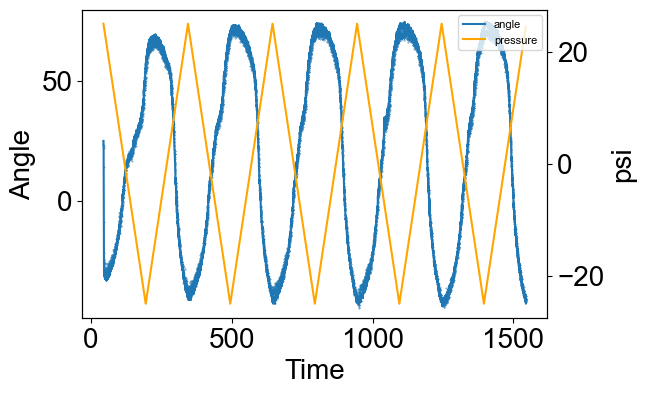

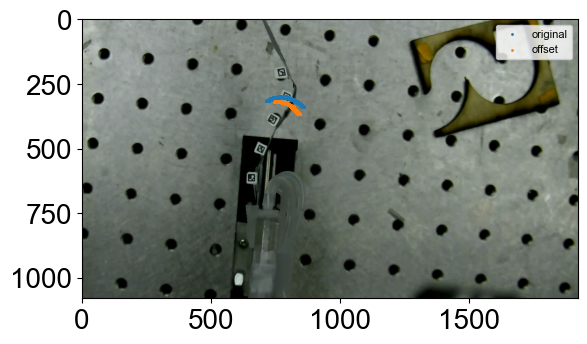

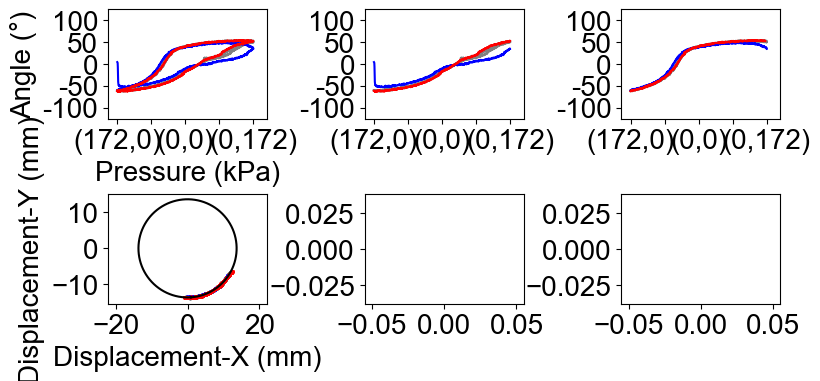

In [90]:
index_of_tag = 2
index_of_actuator = 2
n_cycle = 5
base_angle = 20

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 3, figsize = (8, 4))
fig.tight_layout()
print(f"ax_angle: {np.shape(ax_angle)}")
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time

        top_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])
        top_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][top_mask] - base_angle
        bot_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])
        bot_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][bot_mask] - base_angle
        print(f"top_y_mask: {top_mask}, bot_y_mask: {bot_mask}")
        print(f"top_y: {top_y}, bot_y: {bot_y}")
        #print(camera_data_dict['t_cycle_top'][tag_of_desired])
        line = ax_angle[0][1].plot((camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]), 
                top_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        line = ax_angle[0][2].plot((camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]), 
                bot_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1][0]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    #ax.legend()
print(lines)
for i, ax in enumerate(ax_angle[0]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        # legend = ax.legend(legend_handles, legend_labels, ncol=1, 
        #                 labelspacing=0.1, 
        #                 columnspacing =0.05,
        #                 loc='upper right', 
        #                 handletextpad=0.1, 
        #                 fontsize=fontsize_legend
        #                 )

for i, ax in enumerate(ax_angle[1]):
    ax.axis('equal')
    #ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    #if i == 0:
        #ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

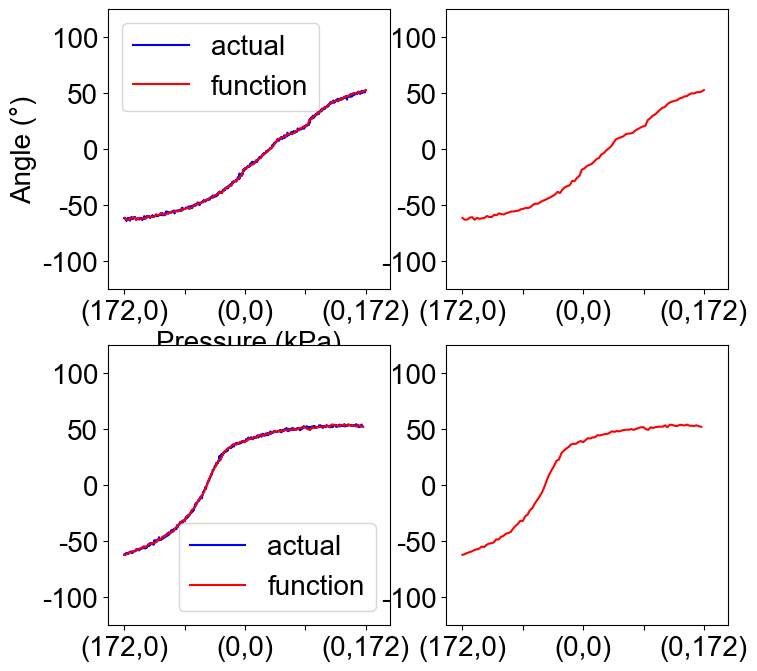

In [91]:

fig, axs = plt.subplots(2, 2, figsize = (8, 8))
top_x = camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]
top_func = scipy.interpolate.interp1d(top_x, top_y)
x = np.linspace(min(top_x), max(top_x), 100)
axs[0][0].plot(top_x, top_y, color = "blue", label = "actual") #plotting angle vs time
axs[0][0].plot(x, top_func(x), color = "red", label = "function")
axs[0][1].plot(x, top_func(x), color = "red", label = "function")
axs[0][0].legend()

bot_x = camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]
bot_func = scipy.interpolate.interp1d(bot_x, bot_y, fill_value = "extrapolate", kind = "quadratic")
x = np.linspace(min(bot_x), max(bot_x), 100)
axs[1][0].plot(bot_x, bot_y, color="blue", label = "actual")
axs[1][0].plot(x, bot_func(x), color = "red", label = "function")
axs[1][1].plot(x, bot_func(x), color = "red", label = "function")
axs[1][0].legend()

for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )

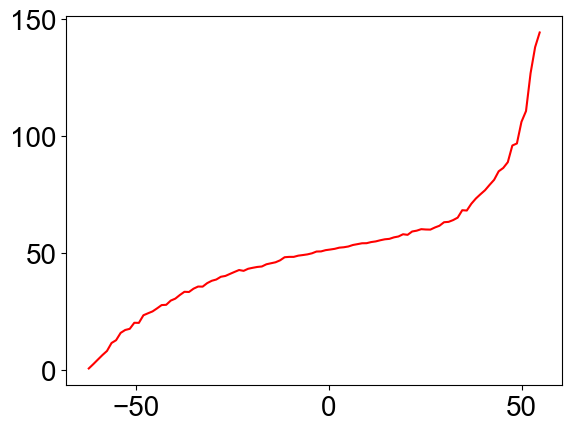

In [94]:
top_func_inverted = scipy.interpolate.interp1d(top_y, top_x, fill_value = "extrapolate")
bot_func_inverted = scipy.interpolate.interp1d(bot_y, bot_x, fill_value = "extrapolate")
import utils_file
folder_name = f"{utils_file.getCurrPath()}/Data"

if utils_file.isPath(f"{folder_name}/data.pickle"):
    saved_data = utils_file.openFile(folder_name)

    saved_data["top_function_3"] = top_func_inverted
    saved_data["bottom_function_3"] = bot_func_inverted

    utils_file.saveFile(folder_name, saved_data)
                
else:
    data = {"top_function_3": top_func_inverted, "bottom_function_3": bot_func_inverted}
    utils_file.saveFile(folder_name, data)

saved_data = utils_file.openFile(folder_name)
top_func = saved_data["top_function_3"]
bot_func = saved_data["bottom_function_3"]
y = np.linspace(min(bot_y), max(bot_y), 100)
plt.plot(y, bot_func(y), color = "red", label = "function")

In [96]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240823_12-25-23_act4",
]

tag_offset_dict = {
    5: {
        'rot': 180,
        'disp': [-3.25, -3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240823_12-25-23_act4/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240823_12-25-23_act4/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240823_12-25-23_act4/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_4', 'camera_5', 'camera_10', 'camera_3', 'camera_2', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_17', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


ax_angle: (2, 3)
n cycle 5 cycle len 200
{4: array([  17.54905438,   17.62892079,   17.8338325 , ..., 1518.2685256 ,
       1518.47634053, 1518.66845989]), 5: array([  17.54905438,   17.62892079,   17.8338325 , ..., 1518.2685256 ,
       1518.47634053, 1518.66845989]), 10: array([  17.54905438,   17.62892079,   17.8338325 , ..., 1518.2685256 ,
       1518.47634053, 1518.66845989]), 3: array([  17.54905438,   17.62892079,   17.8338325 , ..., 1518.2685256 ,
       1518.47634053, 1518.66845989]), 2: array([  17.54905438,   17.62892079,   17.8338325 , ..., 1518.2685256 ,
       1518.47634053, 1518.66845989])}
fitted circle: x 628.89 y 467.96 r 282.74 sigma 8.76
fitted circle: x 8.13 y -21.63 r 48.04 sigma 1.01
angles -85.9373246838571 274.0430523132616
start_idx: 1503, end_idx: 3004
top_y_mask: [ True  True  True ... False False False], bot_y_mask: [False False False ...  True  True  True]
top_y: [-46.07704    -46.07704    -46.07704    -46.07704    -47.070847
 -47.4093     -47.027832   -47

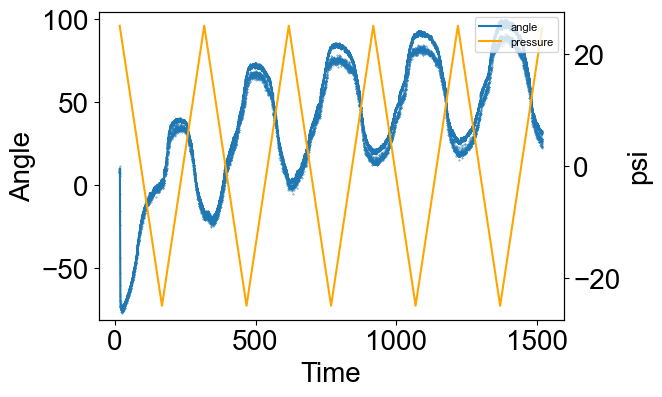

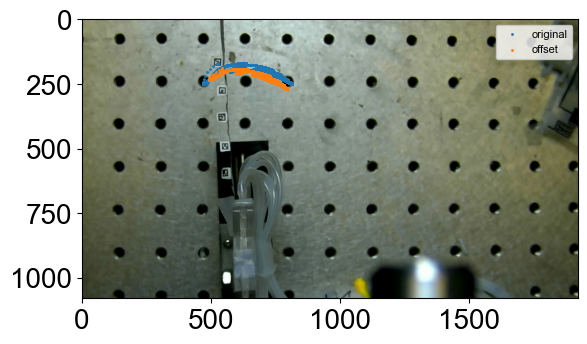

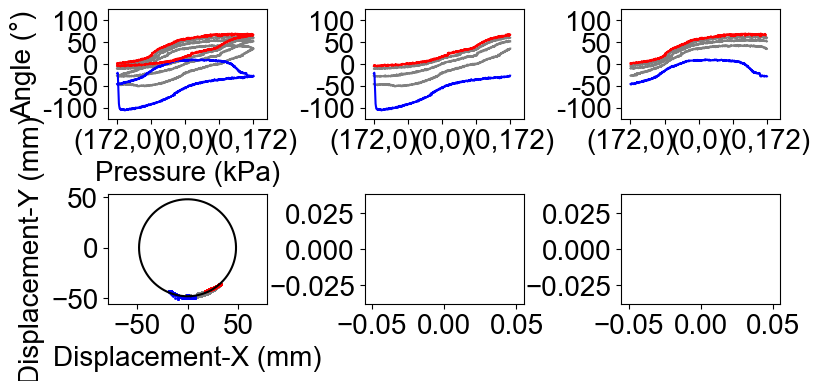

In [97]:
index_of_tag = 3
index_of_actuator = 3
n_cycle = 5
base_angle = 30

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 3, figsize = (8, 4))
fig.tight_layout()
print(f"ax_angle: {np.shape(ax_angle)}")
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0][0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time

        top_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])
        top_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][top_mask] - base_angle
        bot_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])
        bot_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][bot_mask] - base_angle
        print(f"top_y_mask: {top_mask}, bot_y_mask: {bot_mask}")
        print(f"top_y: {top_y}, bot_y: {bot_y}")
        #print(camera_data_dict['t_cycle_top'][tag_of_desired])
        line = ax_angle[0][1].plot((camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]), 
                top_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        line = ax_angle[0][2].plot((camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]), 
                bot_y,
                linestyle='-',
                label=f'#{i+1}',
                color=color
                )
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1][0]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    #ax.legend()
print(lines)
for i, ax in enumerate(ax_angle[0]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        # legend = ax.legend(legend_handles, legend_labels, ncol=1, 
        #                 labelspacing=0.1, 
        #                 columnspacing =0.05,
        #                 loc='upper right', 
        #                 handletextpad=0.1, 
        #                 fontsize=fontsize_legend
        #                 )

for i, ax in enumerate(ax_angle[1]):
    ax.axis('equal')
    #ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    #if i == 0:
        #ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

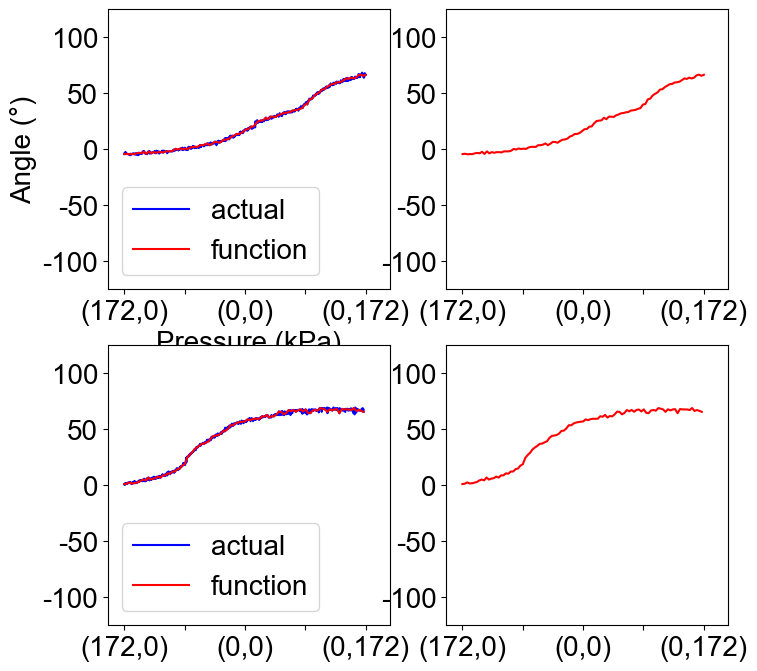

In [98]:

fig, axs = plt.subplots(2, 2, figsize = (8, 8))
top_x = camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]
top_func = scipy.interpolate.interp1d(top_x, top_y)
x = np.linspace(min(top_x), max(top_x), 100)
axs[0][0].plot(top_x, top_y, color = "blue", label = "actual") #plotting angle vs time
axs[0][0].plot(x, top_func(x), color = "red", label = "function")
axs[0][1].plot(x, top_func(x), color = "red", label = "function")
axs[0][0].legend()

bot_x = camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]
bot_func = scipy.interpolate.interp1d(bot_x, bot_y, fill_value = "extrapolate", kind = "quadratic")
x = np.linspace(min(bot_x), max(bot_x), 100)
axs[1][0].plot(bot_x, bot_y, color="blue", label = "actual")
axs[1][0].plot(x, bot_func(x), color = "red", label = "function")
axs[1][1].plot(x, bot_func(x), color = "red", label = "function")
axs[1][0].legend()

for i, ax in enumerate(axs.flatten()):
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )

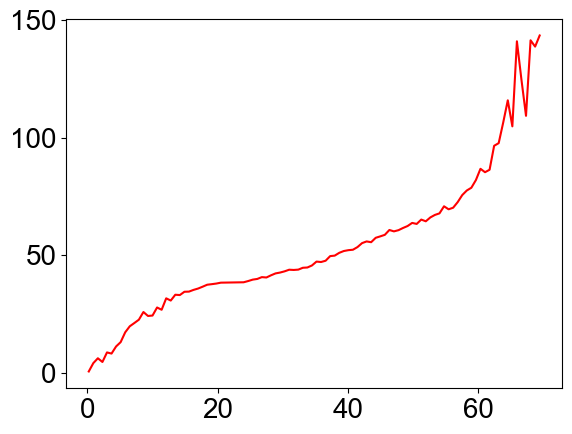

In [100]:
top_func_inverted = scipy.interpolate.interp1d(top_y, top_x, fill_value = "extrapolate")
bot_func_inverted = scipy.interpolate.interp1d(bot_y, bot_x, fill_value = "extrapolate")
import utils_file
folder_name = f"{utils_file.getCurrPath()}/Data"

if utils_file.isPath(f"{folder_name}/data.pickle"):
    saved_data = utils_file.openFile(folder_name)

    saved_data["top_function_4"] = top_func_inverted
    saved_data["bottom_function_4"] = bot_func_inverted

    utils_file.saveFile(folder_name, saved_data)
                
else:
    data = {"top_function_4": top_func_inverted, "bottom_function_4": bot_func_inverted}
    utils_file.saveFile(folder_name, data)

saved_data = utils_file.openFile(folder_name)
top_func = saved_data["top_function_4"]
bot_func = saved_data["bottom_function_4"]
y = np.linspace(min(bot_y), max(bot_y), 100)
plt.plot(y, bot_func(y), color = "red", label = "function")